In [4]:
import matplotlib.pyplot as plt
from google.colab import files
import io
import pandas as pd

data = files.upload()

Saving weatherHistory.csv to weatherHistory.csv


In [5]:
import seaborn as sns
import scipy.stats as stats
import numpy as np

In [9]:
df = pd.read_csv(io.StringIO(data["weatherHistory.csv"].decode("utf-8")))

In [10]:
print(df.shape)
print(df.info())
print(df.describe(include='all'))

(96453, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB
None
                       Formatted Date        Summary

In [11]:
df = df.drop_duplicates(['Formatted Date'], keep='first')
print(df.shape)

(96429, 12)


In [12]:
df.sort_values(by=['Formatted Date'], inplace=True)
df.reset_index(inplace=True, drop=True)


In [13]:
df = df.drop(columns=['Loud Cover', 'Formatted Date'])
print(df.isnull().sum(axis=0) * 100/len(df))


Summary                     0.000000
Precip Type                 0.536146
Temperature (C)             0.000000
Apparent Temperature (C)    0.000000
Humidity                    0.000000
Wind Speed (km/h)           0.000000
Wind Bearing (degrees)      0.000000
Visibility (km)             0.000000
Pressure (millibars)        0.000000
Daily Summary               0.000000
dtype: float64


In [14]:
df = df[df['Precip Type'].notna()]


<Axes: >

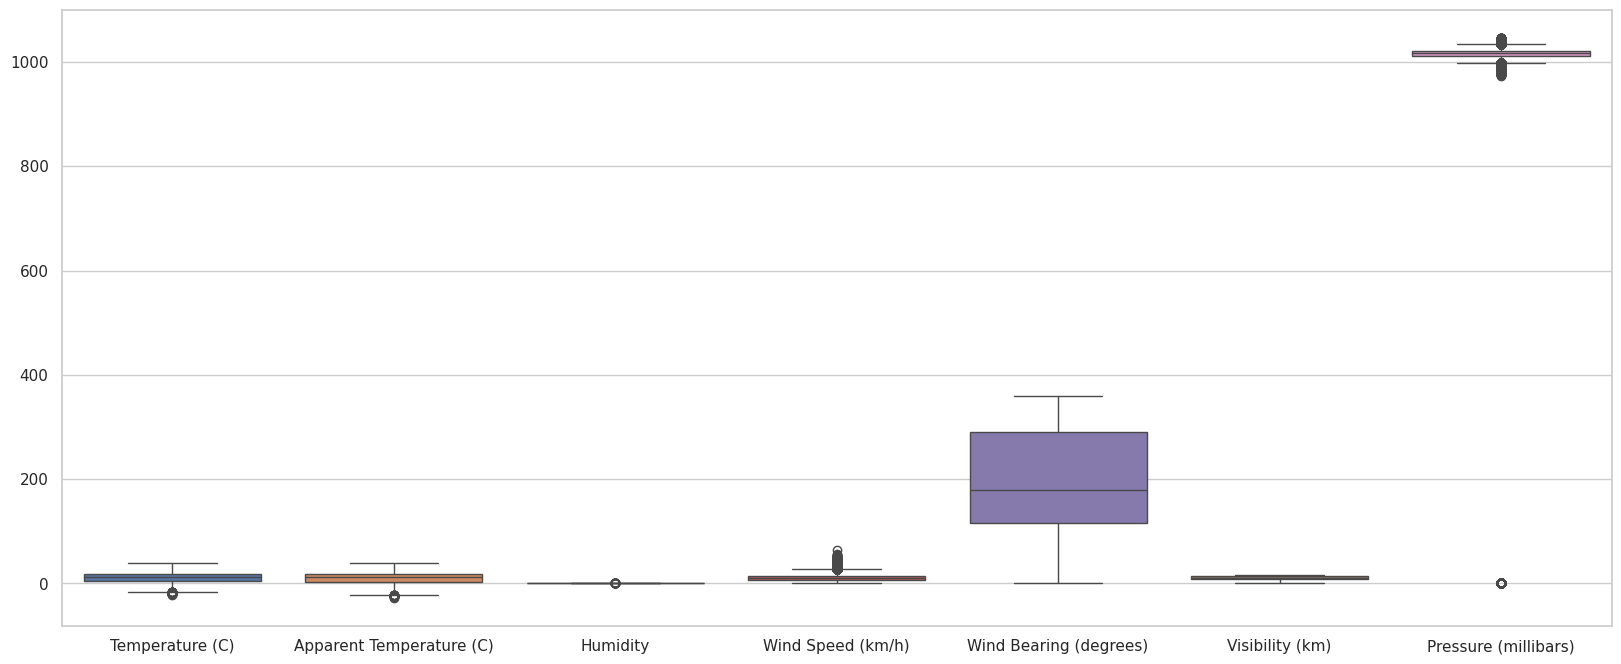

In [15]:
sns.set(rc={'figure.figsize':(20,8)}, style='whitegrid')
sns.boxplot(data=df)

In [16]:
df = df[df['Humidity'] != 0.0]
df = df[df['Wind Speed (km/h)'] <= 60]
df = df[df['Pressure (millibars)'] > 0]
df.reset_index(inplace=True, drop=True)
print(df.shape)

(94601, 10)


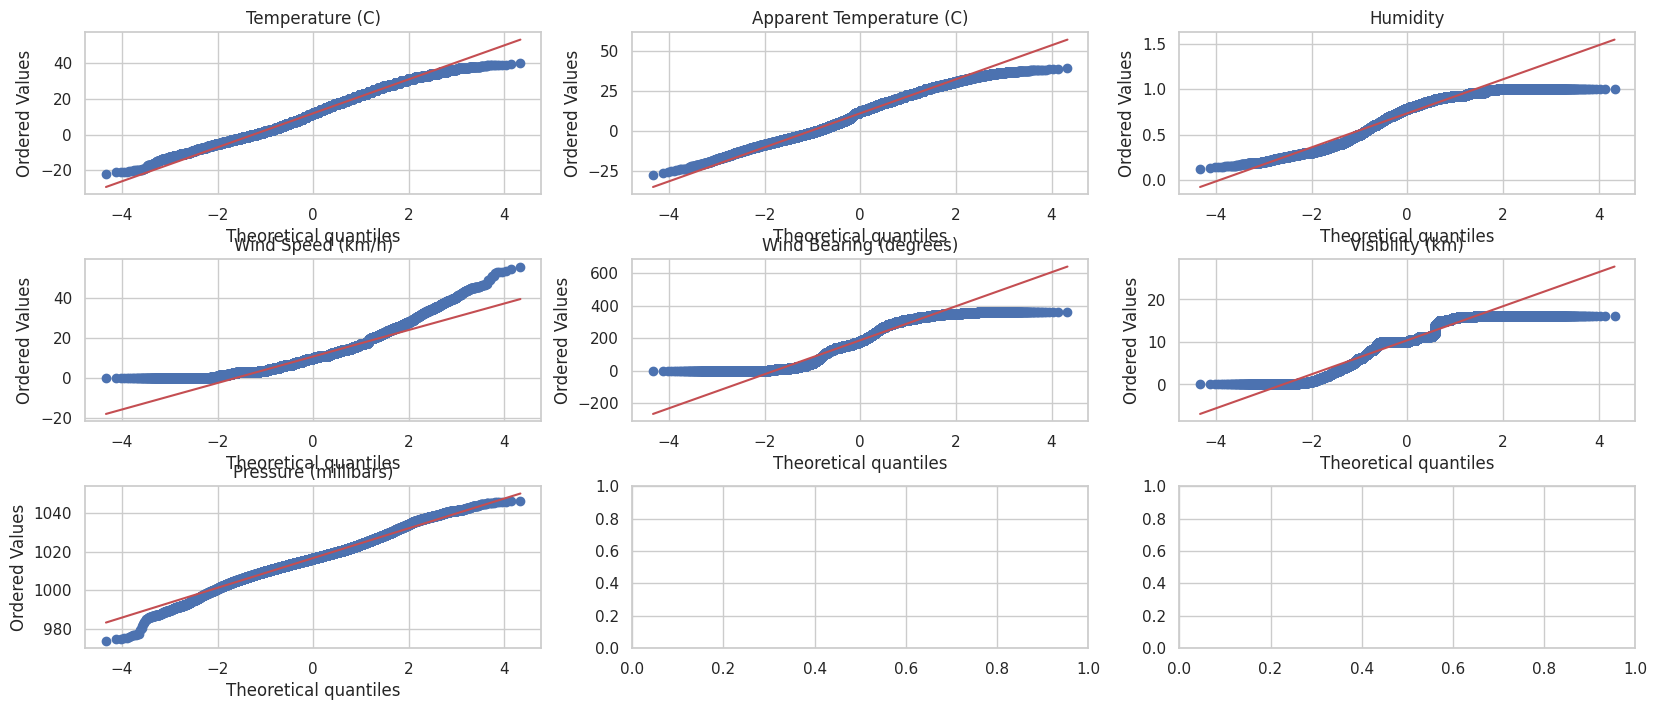

In [17]:
fig, axes = plt.subplots(3,3)
plt.subplots_adjust(hspace = 0.4)
for i, column in enumerate(df.columns[2:9]):
    stats.probplot(df[column], dist="norm", plot=axes[int(i/3)][i%3])
    axes[int(i/3)][i%3].set_title(column)
plt.show()

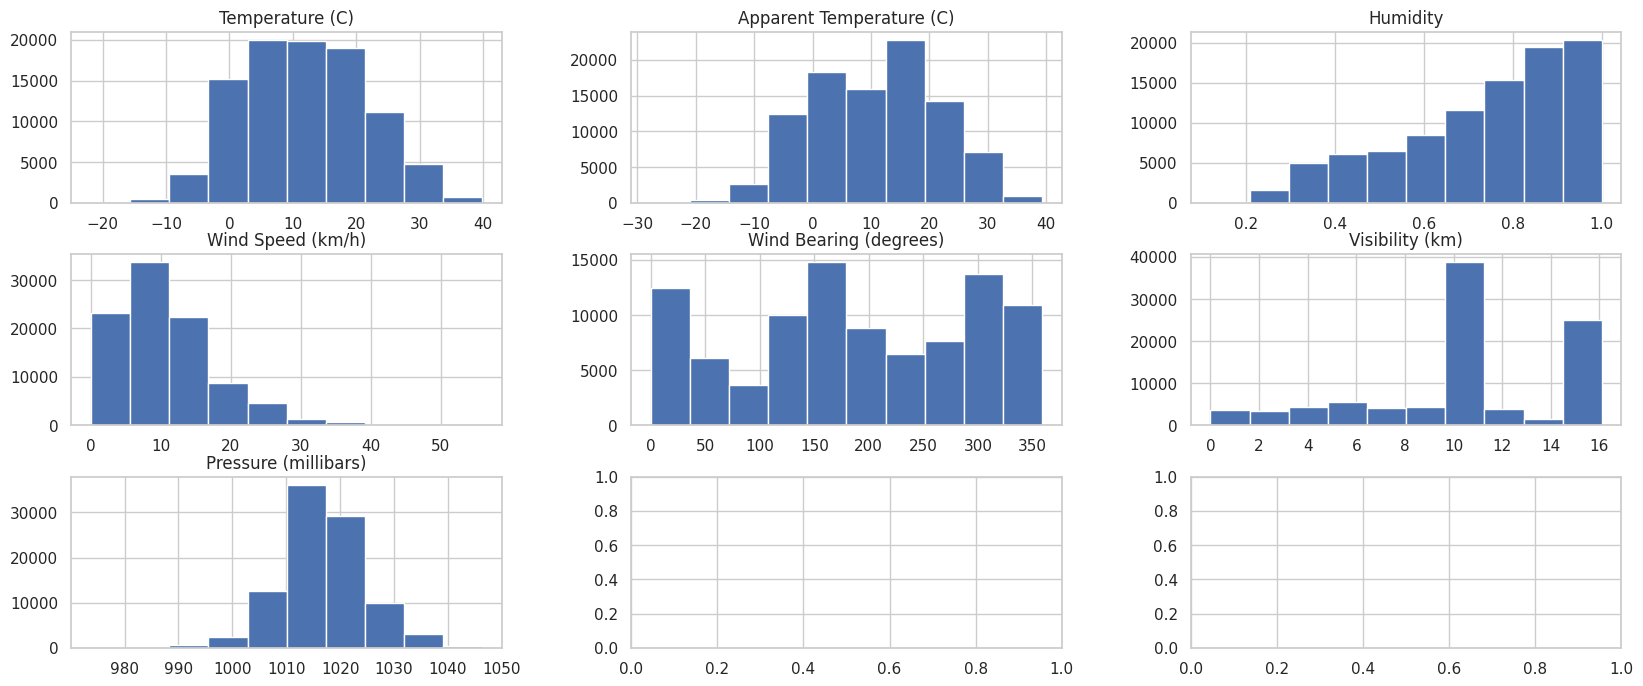

In [18]:
ig, axes = plt.subplots(3,3)
for i, column in enumerate(df.columns[2:9]):
    temp_df = pd.DataFrame(df[column], columns=[column])
    temp_df.hist(ax=axes[int(i/3)][i%3])
plt.show()

In [19]:
from sklearn.preprocessing import FunctionTransformer

# squre root transformation for 'Wind Speed'
feature_name = 'Wind Speed (km/h)_sqrt'
sqrt_transformer = FunctionTransformer(np.sqrt, validate=True)
data_transformed = sqrt_transformer.transform(df[['Wind Speed (km/h)']])
df[feature_name] = data_transformed

# power transformation with power of 2 for 'Humidity'
feature_name = 'Humidity_power2'
power_transformer = FunctionTransformer(lambda x: x**2, validate=True)
data_transformed = power_transformer.transform(df[['Humidity']])
df[feature_name] = data_transformed


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


In [20]:
df['Precip Type'] = df['Precip Type'].astype('category').cat.codes
encoded_summary = pd.get_dummies(df['Summary'])
encoded_daily_summary = pd.get_dummies(df['Daily Summary'])
df = df.join(encoded_summary)
df = df.join(encoded_daily_summary)
df = df.drop(columns=['Daily Summary', 'Summary'])

In [22]:
from sklearn.model_selection import train_test_split
df_data = df.drop('Apparent Temperature (C)', axis=1)
df_target = pd.DataFrame(df['Apparent Temperature (C)'], columns=['Apparent Temperature (C)'])
x_train, x_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.2, random_state=42)

In [21]:
std_columns = ['Temperature (C)',
               'Humidity',
               'Wind Speed (km/h)',
               'Wind Bearing (degrees)',
               'Visibility (km)',
               'Pressure (millibars)']

In [23]:
from sklearn.preprocessing import StandardScaler
# for feature data
scaler_train = StandardScaler()
scaler_train.fit(x_train[std_columns])
x_train_scaled = scaler_train.transform(x_train[std_columns])
x_test_scaled = scaler_train.transform(x_test[std_columns])
df_x_train_standardized = pd.DataFrame(x_train_scaled, columns = std_columns)
df_x_test_standardized = pd.DataFrame(x_test_scaled, columns = std_columns)
# for target data
scaler_target = StandardScaler()
scaler_target.fit(y_train)
y_train_scaled = scaler_target.transform(y_train)
y_test_scaled = scaler_target.transform(y_test)
df_y_train_standardized = pd.DataFrame(y_train_scaled, columns = ['Apparent Temperature (C)'])
df_y_test_standardized = pd.DataFrame(y_test_scaled, columns = ['Apparent Temperature (C)'])

<Axes: >

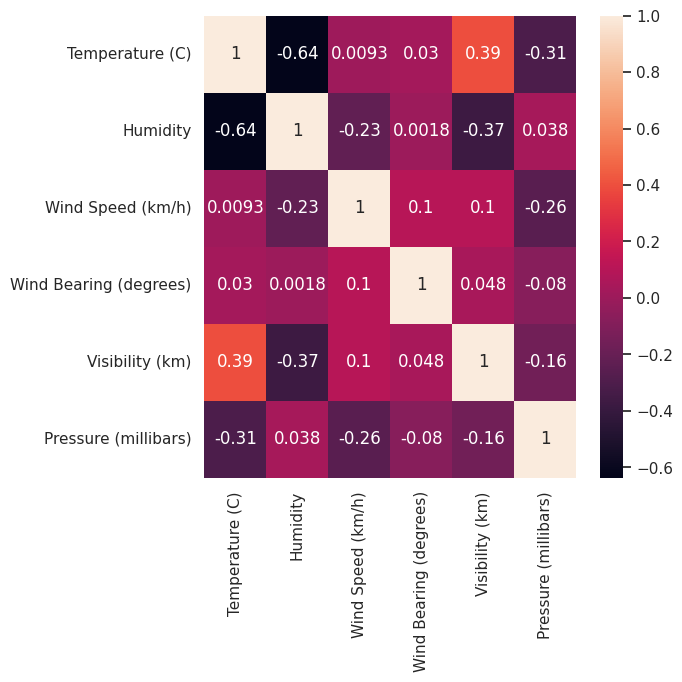

In [24]:
sns.set(rc={'figure.figsize':(6,6)})
sns.heatmap(df_x_train_standardized.corr(), annot=True)

In [25]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train)
pca.explained_variance_ratio_

array([9.81390664e-01, 9.12878824e-03, 5.04783937e-03, 3.09662840e-03,
       1.18526478e-03, 2.78089118e-05, 1.67503866e-05, 1.40628797e-05,
       9.52519361e-06, 7.04689954e-06, 6.43248143e-06, 5.83268626e-06,
       5.06732149e-06, 4.65268408e-06, 4.01278683e-06, 3.53343978e-06,
       3.29053646e-06, 2.96228899e-06, 2.76221878e-06, 2.53289564e-06,
       2.24416679e-06, 2.18720631e-06, 1.86679509e-06, 1.62898941e-06,
       1.33600057e-06, 1.22557415e-06, 1.19063735e-06, 1.14561152e-06,
       1.11236055e-06, 1.02961517e-06, 9.26768137e-07, 8.19874989e-07,
       7.73340383e-07, 6.72768333e-07, 6.54322259e-07, 6.01807164e-07,
       5.14655400e-07, 4.69125436e-07, 4.61542520e-07, 4.28353277e-07,
       3.88667598e-07, 3.80926195e-07, 3.67571508e-07, 3.58411004e-07,
       3.48465967e-07, 3.40567911e-07, 3.25967867e-07, 3.04253178e-07,
       2.90344418e-07, 2.67709092e-07, 2.59812202e-07, 2.56661560e-07,
       2.49868190e-07, 2.43882194e-07, 2.35475485e-07, 2.25666706e-07,
      

In [26]:
pca = PCA(n_components=11)
pca.fit(x_train)
pca_x_train = pca.transform(x_train)
pca_x_test = pca.transform(x_test)

In [27]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
model = lm.fit(pca_x_train, y_train)

In [28]:
predictions = lm.predict(pca_x_train)
y_train_pred = pd.DataFrame(predictions, columns=['Predicted Apparent Temperature (C)'])

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Mean Squred Error
mse = mean_squared_error(y_train, y_train_pred)
print('Mean squared error(Train) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_train, y_train_pred))
print('Root mean squared error(Train) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_train, y_train)
print('Explained variance of the predictions(Train) :', round(score * 100, 4))

Mean squared error(Train) : 1.1101
Root mean squared error(Train) : 1.0536
Explained variance of the predictions(Train) : 99.0316


In [30]:
predictions = lm.predict(pca_x_test)
y_pred = pd.DataFrame(predictions, columns=['Predicted Apparent Temperature (C)'])
# Mean Squred Error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error(Testing) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_test, y_pred))
print('Root mean squared error(Testing) :', round(rmsq, 4))

# Accuracy
score = lm.score(pca_x_test, y_test)
print('Explained variance of the predictions(Testing) :', round(score * 100, 4))

Mean squared error(Testing) : 1.1196
Root mean squared error(Testing) : 1.0581
Explained variance of the predictions(Testing) : 99.0156


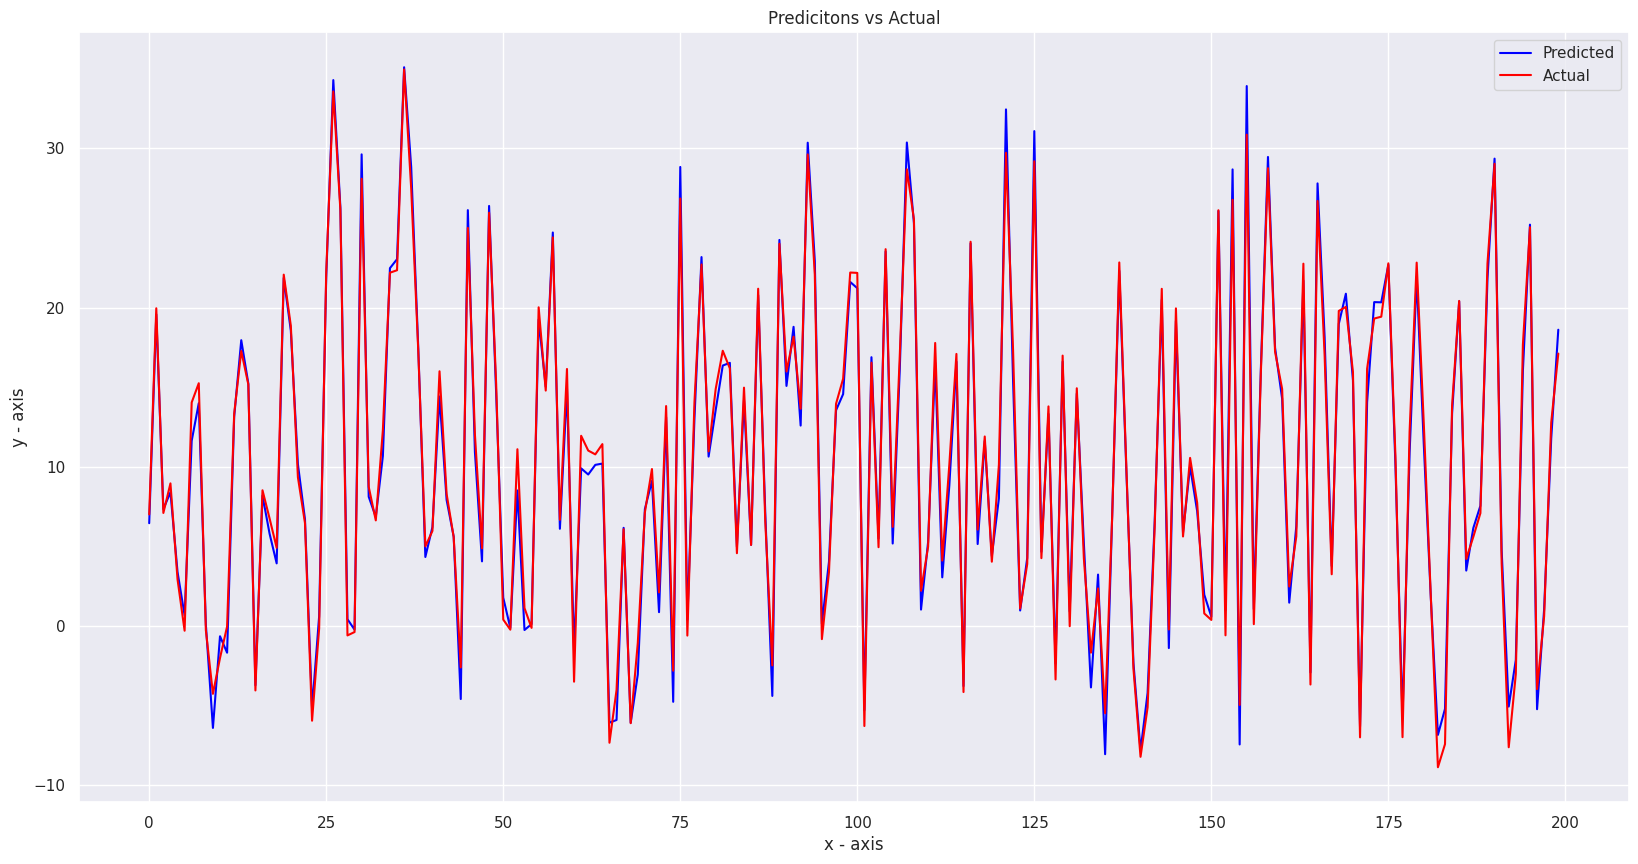

In [35]:
sns.set(rc={'figure.figsize':(20,10)})
x=np.arange(0,200,1)
plt.plot(x,y_pred[:200], label='Predicted', color='blue')
plt.plot(x,y_test[:200], label='Actual', color='red')
plt.xlabel('x - axis')
plt.ylabel('y - axis')
plt.title('Predicitons vs Actual')
plt.legend()
plt.show()